In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.graphics.tsaplots as splt
from statsmodels.tsa.api import VAR
import statsmodels.tsa.seasonal as sts
import statsmodels.api as sm
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

#train_path = "../favorita-grocery-sales-forecasting/train.csv"
train_path = "../data/X_train_subset.csv"
test_path = "../favorita-grocery-sales-forecasting/test.csv"
stores_path = "../favorita-grocery-sales-forecasting/stores.csv"
transactions_path = "../favorita-grocery-sales-forecasting/transactions.csv"
holidays_path = "../favorita-grocery-sales-forecasting/holidays_events.csv"
items_path = "../favorita-grocery-sales-forecasting/items.csv"

In [2]:
%%time
#EDA highlights these values can be recast to optimize memory
dtype = {'id': 'int32',
         'item_nbr': 'int32',
         'store_nbr': 'int8',
         'unit_sales': 'float32'
         }

#EDA shows that 'date' indeed is a date field and should be processed as such
parse_dates = ['date']
date_parse = lambda x: datetime.strptime(x, '%Y-%m-%d')

#REDUCED DATASET
X_train = pd.read_csv(train_path, 
                      low_memory=False,
                      dtype=dtype,
                      parse_dates=parse_dates, 
                      date_parser=date_parse
          )

X_test = pd.read_csv(test_path, 
                     low_memory=False,
                     dtype=dtype,
                     parse_dates=parse_dates, 
                     date_parser=date_parse
          )

CPU times: user 6min 53s, sys: 10.8 s, total: 7min 4s
Wall time: 7min 4s


In [3]:
X = X_train[47230504:].copy()   #REDUCE EVEN MORE GIVEN TIME TAKING TO EXPERIMENT

<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> COMMENTARY  </span> <br>
    <span style="font-size:15px"> The following code aims to develop a naive baseline model that goes through each item sold, determines the average unit_sales per store, and saves that value to a dictionary object </span>
</div>

In [381]:
temp = X_train.groupby('item_nbr')

baseline_model = {}

for item_nbr, item_group in temp:
    
    #all stores that sell the item
    stores = item_group.store_nbr.unique()  
    
    #for each store
    for store_nbr in stores:
              
        #get mean of item's unit sales for each store
        avg = round(item_group[item_group.store_nbr==store_nbr].unit_sales.mean(),2)

        #using dictionary object with key as [item#][store#], set value to avg
        if baseline_model.get(item_nbr, 0):
            
            baseline_model[item_nbr][store_nbr] = avg
            
        else:
            
            baseline_model[item_nbr] = {store_nbr: avg}

In [382]:
def baseline(item_nbr, store_nbr):
    
    if baseline_model.get(item_nbr, 0):
        sums = 0
        n = len(baseline_model[item_nbr])
        for k,v in baseline_model[item_nbr].items():
            sums += v
        avg = round(sums/n,2)
        return_value = baseline_model[item_nbr].get(store_nbr, avg)
        if return_value < 0:
            return 0
        else:
            return return_value
    else:
        #if item # not found in training data--blindly submit 1 unit sale
        return 1

baseline_X_test = X_test.copy()
baseline_X_test['unit_sales'] = [baseline(item_nbr, store_nbr) \
                        for item_nbr, store_nbr in zip(baseline_X_test['item_nbr'], 
                                                       baseline_X_test['store_nbr'])]

In [383]:
baseline_X_test.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion'], axis=1, inplace=True)

In [384]:
baseline_X_test.to_csv("baseline.csv", index=False)

<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> COMMENTARY  </span> <br>
    <span style="font-size:15px"> During EDA it was discovered that the onpromotion field had several NaN values. As semi-informed way to impute those values is the look at the probability over the course of the years that a certain item would be on sale, and then to use that probability to bernouli sample whether that item would be on sale. If time allowed, this effort would be fine-tuned by looking at the probability of an item being sold given a particular month and day of week. This field may come in handy later on in the modeling process.</span>
</div>

In [385]:
X_train['onpromotion_missing'] = [0 if ((promo == True) or (promo == False)) else 1 \
                                    for promo in X_train['onpromotion']]

In [391]:
onpromo_df = pd.DataFrame(X_train[(X_train.onpromotion == True)].item_nbr\
                                                                .value_counts())\
                                                                .reset_index()\
                                                                .rename(columns={'item_nbr':'onpromo_counts', 
                                                                                 'index':'item_nbr'}
             )

offpromo_df = pd.DataFrame(X_train[(X_train.onpromotion == False)].item_nbr\
                                                                  .value_counts())\
                                                                  .reset_index()\
                                                                  .rename(columns={'item_nbr':'offpromo_counts', 
                                                                                   'index':'item_nbr'}
               )

#get every item in the training set that has null values for onpromotion field
items_with_null_onpromtions = X_train[X_train.onpromotion.isnull()].item_nbr.unique()

#for each of those items found...
items_prob = {}
for i, item_nbr in enumerate(items_with_null_onpromtions):
    
    #get the number of times the item was found to be on promotion
    try:
        number_times_item_promo = onpromo_df[onpromo_df.item_nbr == item_nbr].onpromo_counts.values[0]
    except:
        number_times_item_promo = 0
    
    #get the number of times the item was found not to be on promotion
    number_times_item_notpromo = offpromo_df[offpromo_df.item_nbr == item_nbr].offpromo_counts.values[0]
    
    #p is the probability that the item would be on promotion
    p = number_times_item_promo/(number_times_item_promo + number_times_item_notpromo)
    
    #track items prob of being on promotion
    items_prob[item_nbr] = p
    


X_train['onpromotion'] = [promo if ((promo==True) or (promo==False)) \
                                else bool(np.random.binomial(1, items_prob[item_nbr], 1)[0])\
                                for promo, item_nbr in zip(X_train['onpromotion'], X_train['item_nbr'])]





<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> Vector Autoregression Model 1   </span> <br>
    <span style="font-size:15px">   </span>
</div>

In [387]:
#temp_df = X_train[X_train.date.dt.year >=2016].copy()

In [388]:
#temp_df.to_csv("../data/X_train_subset.csv")

In [390]:
X = X_X_traintrain[29519066:].copy() 

In [393]:
X.drop('Unnamed: 0', axis=1, inplace=True)

In [394]:
items = X.groupby('item_nbr')

item_stores = {}

for item_nbr, item_group in items:
    
    df = pd.DataFrame()
    
    #all stores that sell the item
    stores = item_group.groupby('store_nbr')  
    
    for store_nbr, store_grp in stores:
        
        #create a new field representing store#
        field = store_nbr
        
        #mean item unit sales per day
        stores_item_day = store_grp.groupby('date')['unit_sales'].mean()
        
        #fill in missing index/date values
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        
        #with nearest neighbors
        stores_item_day = stores_item_day.reindex(date_index, method='nearest')
        
        #make series into DF
        stores_item_day = pd.DataFrame(stores_item_day)
        
        #rename column with new field name
        stores_item_day.rename(columns={'unit_sales':field}, inplace=True)
        
        if df.empty:
            df = stores_item_day.copy()
        else:
            df = pd.concat([df, stores_item_day[field]], axis=1)
        

    item_stores[item_nbr] = df  

<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> COMMENTARY  </span> <br>
    <span style="font-size:15px">  The code above creates a design matrix representing unit sales per day of an item over time for 54 stores</span>
</div>

In [395]:
item_stores[99197].head(2) #EXAMPLE

,1,2,3,4,6,7,8,23,24,25,...,44,45,46,47,48,49,50,51,52,53
2017-04-26,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,5.0,6.0,1.0,2.0,1.0,7.0,1.0,4.0,2.0,2.0
2017-04-27,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,5.0,6.0,1.0,2.0,1.0,7.0,1.0,4.0,2.0,2.0


<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> COMMENTARY  </span> <br>
    <span style="font-size:15px">  The code below creates VAR models for each item sold</span>
</div>

In [396]:
item_models = {}
reinspect = []
constants = {}

for item in X.item_nbr.unique():
    
    #fetch the dataframe representing items sold in each store
    df = item_stores[item]
    try:
        
        #handling fields with cardinality of 1, which the VAR model does not accept by:
        #first identifying all stores in the dataframe
        cols = df.columns
        #go through each store
        for col in cols:
            #and if the cardinality is 1, then...
            if len(df[col].unique()) == 1:
                #save it to the constants dictionary, which will be used for prediction too
                if constants.get(item,0):
                    constants[item][col] = df[col].unique()[0]
                else:
                    constants[item] = {col:df[col].unique()[0]}
                #then delete the column
                df.drop(col, axis=1, inplace=True)
                
        model = VAR(df)
        item_models[item] = model.fit(1)
        
    except Exception as err:
        #the following items failed to be fitted with a VAR model warranting further inspection
        reinspect.append(item)

<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> COMMENTARY  </span> <br>
    <span style="font-size:15px">  The reinspect variable shows a VAR model could not be created because the lack of data and only having one columns</span>
</div>

In [397]:

reinspect[0]

1066900

In [398]:
item_stores[1066900].head(2)

,46
2017-04-26,6.0
2017-04-27,6.0


In [399]:
reinspect[1]

1116113

In [400]:
item_stores[1116113].head(2)

,21
2017-04-26,7.0
2017-04-27,7.0


In [401]:
col = item_stores[1116113].columns[0]
series = item_stores[1116113][col]
series.mean()

3.4642856121063232

In [402]:
idx = pd.date_range('2017-08-16','2017-08-31')
pd.DataFrame(constants[903286], index=idx)

,10,13,54
2017-08-16,10.246,5.133,2.615
2017-08-17,10.246,5.133,2.615
2017-08-18,10.246,5.133,2.615
2017-08-19,10.246,5.133,2.615
2017-08-20,10.246,5.133,2.615
2017-08-21,10.246,5.133,2.615
2017-08-22,10.246,5.133,2.615
2017-08-23,10.246,5.133,2.615
2017-08-24,10.246,5.133,2.615
2017-08-25,10.246,5.133,2.615


In [403]:
item_forecast = {}
items_not_modeled = []
for item in X_test.item_nbr.unique():
    
    if item in reinspect:
        col = item_stores[item].columns[0]
        series = item_stores[item][col]
        item_forecast[item] = series.mean()

    elif item in list(constants.keys()):
        idx = pd.date_range('2017-08-16','2017-08-31')
        item_forecast[item] = pd.DataFrame(constants[item], index=idx)
        
    elif item_models.get(item, 0):
 
        #Get item's model
        model = item_models[item]
        
        #retrieve the fitted values
        df = model.fittedvalues
        
        #the store numbers are equal to the column values
        store_nbrs = df.columns
        
        #forecast 15 days
        f = model.forecast_interval(y=df.values[-model.k_ar:], steps=16)
        
        #set up the dataframe
        idx = pd.date_range('2017-08-16','2017-08-31')
        df_forecast = pd.DataFrame(f[0],index=idx,columns=store_nbrs)
        
        item_forecast[item] = df_forecast
        
    else:
        items_not_modeled.append(item)
        

/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1242: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1242: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1242: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))


In [404]:
items_not_modeled[0]

313094

In [406]:
def forecast(date, store, item):
    try:
        forecasted_value = item_forecast[item][store][date]
        if forecasted_value < 0:
            return 1
        else:
            return forecasted_value
    except:
            forecasted_value = 1
    return forecasted_value
X_test['unit_sales'] = [forecast(d, s, i) for d,s,i in zip(X_test['date'],X_test['store_nbr'],X_test['item_nbr'])]

In [407]:
var1_X_test = X_test.copy()

In [408]:
var1_X_test.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion'], axis=1, inplace=True)

In [409]:
var1_X_test.to_csv("var1.csv", index=False)

In [410]:
X_test.drop('unit_sales', axis=1, inplace=True)

In [411]:
del item_stores

<div style="background-color:#9FC6E5">
    <span style="font-size:25px"> Vector Autoregression Model 2  </span> <br>
    <span style="font-size:15px">   </span>
</div>

In [4]:
stores = X.groupby('store_nbr')

In [5]:
store_items = {}

for store_nbr, store_group in stores:
    
    df = pd.DataFrame()
    
    #all items sold at this store
    items = store_group.groupby('item_nbr') 
    
    for item_nbr, item_grp in items:

        #make the item a field name
        field = item_nbr

        #get the mean unit_sales of the item by date
        stores_item_day = item_grp.groupby('date')['unit_sales'].mean()

        #fill in missing index/date values...
        date_index = pd.date_range('2017-04-26', '2017-08-15')

        #with the nearest neighbors
        stores_item_day = stores_item_day.reindex(date_index, method='nearest')

        #make series into DF
        stores_item_day = pd.DataFrame(stores_item_day)
        
        #rename column with new field name
        stores_item_day.rename(columns={'unit_sales':field}, inplace=True)
        
        #add to dataframe that will be stored in dictionary object below
        if df.empty:
            df = stores_item_day.copy()
        else:
            df = pd.concat([df, stores_item_day[field]], axis=1)
            
       
    store_items[store_nbr] = df

In [85]:
store_items[1].head(2)

,96995,99197,103520,103665,105574,105575,105577,105693,105737,105857,...,2110456,2111684,2111870,2112404,2113343,2113914,2114566,2116416,2122188,2124052
2017-04-26,1.0,1.0,2.0,3.0,10.0,4.0,3.0,3.0,1.0,4.0,...,3.0,8.0,8.0,8.0,4.0,6.0,1.0,3.0,3.0,1.0
2017-04-27,1.0,1.0,2.0,3.0,10.0,4.0,3.0,3.0,1.0,4.0,...,3.0,8.0,8.0,8.0,4.0,6.0,1.0,3.0,3.0,1.0


In [6]:
store_models = {}
reinspect = []
constants = {}

#go through each store
for store in X.store_nbr.unique():
    
    #fetch the dataframe built in the code cell above made up of store's daily unit sales of items
    df = store_items[store]
    
    try:
        
        #the VAR model does not accept fields with cardinality of 1 or 2, 
        #so remove those as constant predictions:
        items = df.columns
        
        #go through each item
        for item in items:
            
            #if the item has the same sales cardinality of 1 or 2, then...
            if len(df[item].unique()) == 1 or len(df[item].unique()) == 2:
                
                #save it to the constants dictionary, which will be used for prediction
                if constants.get(store,0):
                    constants[store][item] = df[item].unique()[0]
                else:
                    constants[store] = {item:df[item].unique()[0]}
                    
                #then delete the column
                df.drop(item, axis=1, inplace=True)
        
        #create the VAR model
        model = VAR(df)
        
        #fit it
        store_models[store] = model.fit(1)
        
    except Exception as err:
        print(err)
        #the following items failed to be fitted with a VAR model warranting further inspection
        reinspect.append(store)

In [95]:
store_models[1]

In [100]:
reinspect

[]

In [8]:
store_forecast = {}
stores_not_modeled = []
for store in X.store_nbr.unique():
    
    if store_models.get(store, 0):
 
        #Get item's model
        model = store_models[store]
        
        #retrieve the fitted values
        df = model.fittedvalues
        
        #the store numbers are equal to the column values
        items = df.columns
        
        #forecast 15 days
        f = model.forecast_interval(y=df.values[-model.k_ar:], steps=16)
        
        #set up the dataframe
        idx = pd.date_range('2017-08-16','2017-08-31')
        df_forecast = pd.DataFrame(f[0],index=idx,columns=items)
        
        store_forecast[store] = df_forecast
        
    else:
        stores_not_modeled.append(store)

In [10]:
#some items are new and no history of unit sales exists. 
#An attempt to guess the unit sales of these items is to look 
#at what family they belong to
items_df = pd.read_csv(items_path)
average_unit_sale_of_familytype_with_promo = {}
average_unit_sale_of_familytype_without_promo ={}
X_with_items = X.merge(items_df, on=['item_nbr'], how='inner')

X_with_items_on_promo = X_with_items[X_with_items.onpromotion == True]
X_with_items_on_promo_family = X_with_items_on_promo.groupby("family")
for family_name, family_group in X_with_items_on_promo_family:
    average_unit_sale_of_familytype_with_promo[family_name] = family_group.unit_sales.mean()

X_with_items_not_promo = X_with_items[X_with_items.onpromotion == False]
X_with_items_not_promo_family = X_with_items_not_promo.groupby("family")
for family_name, family_group in X_with_items_not_promo_family:
    average_unit_sale_of_familytype_without_promo[family_name] = family_group.unit_sales.mean()

In [12]:
average_unit_sale_of_familytype_without_promo

{'AUTOMOTIVE': 1.6052312850952148,
 'BABY CARE': 1.6169590950012207,
 'BEAUTY': 1.9257704019546509,
 'BEVERAGES': 10.227813720703125,
 'BOOKS': 1.2333333492279053,
 'BREAD/BAKERY': 7.933053970336914,
 'CELEBRATION': 1.97347891330719,
 'CLEANING': 4.761221408843994,
 'DAIRY': 6.33254337310791,
 'DELI': 5.688411712646484,
 'EGGS': 8.853487014770508,
 'FROZEN FOODS': 6.798976421356201,
 'GROCERY I': 6.208569526672363,
 'GROCERY II': 6.803553581237793,
 'HARDWARE': 1.5102143287658691,
 'HOME AND KITCHEN I': 2.6738767623901367,
 'HOME AND KITCHEN II': 2.2579782009124756,
 'HOME APPLIANCES': 1.6244251728057861,
 'HOME CARE': 4.432539463043213,
 'LADIESWEAR': 2.202646017074585,
 'LAWN AND GARDEN': 3.5345726013183594,
 'LINGERIE': 1.955878734588623,
 'LIQUOR,WINE,BEER': 5.411430358886719,
 'MAGAZINES': 2.664297342300415,
 'MEATS': 11.385858535766602,
 'PERSONAL CARE': 4.1551713943481445,
 'PET SUPPLIES': 2.25636887550354,
 'PLAYERS AND ELECTRONICS': 2.048719882965088,
 'POULTRY': 14.2388992309

In [13]:
item_family_map = {}
for index, row in X_with_items.iterrows():
    item_family_map[row['item_nbr']] = row['family']

In [111]:
store_df.type.unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [37]:
X_with_items_stores = X_with_items.merge(store_df, on='store_nbr', how='inner')

,Unnamed: 0,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster
0,113689412,113689412,2017-04-26,28,1281253,2.0,False,GROCERY I,1056,0,Guayaquil,Guayas,E,10
1,113791012,113791012,2017-04-27,28,1281253,3.0,False,GROCERY I,1056,0,Guayaquil,Guayas,E,10


In [43]:
store_type_map = {}
for store_name, store_group in X_with_items_stores.groupby('store_nbr'):
    store_type = store_group.type.unique()[0]
    store_type_map[store_name] = store_type

In [64]:
def forecast(date, store, item, promo):
    
    try:
        forecasted_value = store_forecast[store][item][date]
        if forecasted_value < 0:
            return 1
        else:
            return forecasted_value
    except:
        
        try:         
            forecasted_value = constants[store][item]
            return forecasted_value
        except:
            
            stores = list(range(1,55))
            for s in stores:
                try:
                    forecasted_value = store_forecast[s][item][date]
                    return forecasted_value
                except: 
                    pass
            return 1


X_test['unit_sales'] = [forecast(d, s, i, p) for d,s,i,p in zip(X_test['date'], X_test['store_nbr'],
                                                                X_test['item_nbr'], X_test['onpromotion'])]

In [61]:
var4_X_test = X_test.copy()
var4_X_test.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion'], axis=1, inplace=True)
var4_X_test.to_csv("var4.csv", index=False)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. For this section, plans is to expirement with Dr. Elston's suggestion of using Vector Autoregression (VAR). To complete this step, I need to create columns representing each store and its transaction. Then, as a test I can use the VAR model on the data after adjusting the series for unit variance, detrending, and adjusting for seasonality  </span>
</div>

In [200]:
transactions_df = pd.read_csv(transactions_path)

In [201]:
transactions_df.sample(3)

,date,store_nbr,transactions
76342,2017-04-05,22,761
40022,2015-05-04,33,1147
52750,2016-01-10,44,5220


In [202]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'], format='%Y-%m-%d').dt.tz_localize(None)

In [203]:
transactions_df.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. The plot below shows store 44's daily transactions before any adjustments  </span>
</div>

<AxesSubplot:xlabel='date'>

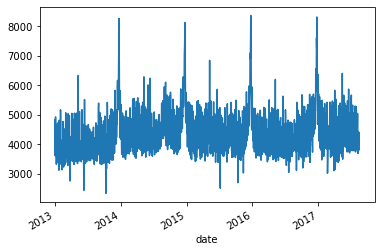

In [204]:
transactions_df.groupby(['store_nbr', 'date'])['transactions'].mean()[44].plot()

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. Now the code for making the adjustments  </span>
</div>

In [205]:
holiday_df = pd.read_csv(holidays_path)
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
        4:'Friday', 5:'Saturday', 6:'Sunday'}
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 
      5:'May', 6:'Jun', 7:'Jul',
      8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',
      12:'Dec'}

Hs = list(holiday_df['date'].unique())

new_years_2 = ['2013-12-30', '2014-12-30', '2015-12-30', '2016-12-30', '2017-12-30']
new_years_1 = ['2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31']
new_years_0 = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', 
               '2016-01-04']

mothers_day_celebrations =['2013-05-11', '2014-05-10','2015-05-09','2016-05-07', 
                           '2017-05-13']

Navidad_6 = ['2013-12-19', '2014-12-19', '2015-12-19', '2016-12-19', '2017-12-19']
Navidad_5 = ['2013-12-20', '2014-12-20', '2015-12-20', '2016-12-20', '2017-12-20']
Navidad_4 = ['2013-12-21', '2014-12-21', '2015-12-21', '2016-12-21', '2017-12-21']
Navidad_3 = ['2014-12-22', '2015-12-22', '2016-12-22', '2017-12-22']
Navidad_2 = ['2013-12-23', '2014-12-23', '2015-12-23', '2016-12-23', '2017-12-23']
Navidad_1 = ['2013-12-24', '2014-12-24', '2015-12-24', '2016-12-24', '2017-12-24']
Navidad_0 = ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']
Navidadp1 = ['2013-12-26', '2014-12-26', '2015-12-26', '2016-12-26', '2017-12-26']


significant_dates = new_years_0 + new_years_1 + new_years_2 + \
                    mothers_day_celebrations + Navidad_4 + Navidad_3 + \
                    Navidad_2 + Navidad_1 + Navidad_0 + Navidadp1

holidays = []
for h in Hs:
    if h not in significant_dates:
        holidays.append(h)
        
categorical_features = ['day_of_week', 'month', 'year']
numerical_features = ['holiday', 'new_years_1_2', 'new_year', 'mothers_celebration',
                      'Navidad_6', 'Navidad_5', 'Navidad_4', 'Navidad_3', 'Navidad_2', 'Navidad_1', 'Navidad_0', 'Navidadp1']

In [206]:
df = pd.DataFrame()

for store_num, store_grp in transactions_df.groupby('store_nbr'):
    #get the mean unit_sales of the item by date
    s = store_grp.groupby('date')['transactions'].mean()

    #fill in missing index/date values...
    date_index = pd.date_range('2013-01-01', '2017-08-15')

    #with the nearest neighbors
    s = s.reindex(date_index, method='nearest')

    #make series into DF
    s = pd.DataFrame(s).rename(columns={"transactions": store_num})
    
    
    #ADJUST SERIES FOR UNIT VARIANCE
    mean_transaction = s[store_num].mean()
    std_transaction = s[store_num].std()
    transactions_wUnitVariance = (s[store_num] - mean_transaction)/std_transaction
    s[store_num] = transactions_wUnitVariance
    
    #REMOVE TREND
    baseDF = s.copy()
    t_times = len(baseDF.index)
    baseDF['time_t'] = np.arange(t_times)
    time_t = baseDF.loc[:, ['time_t']]
    y = baseDF.loc[:, store_num]
    y, time_t = y.align(time_t, join='inner')  
    reg = LinearRegression().fit(time_t, y)
    trend = pd.Series(reg.predict(time_t), index=time_t.index)
    y_untrended = y - trend
    s[store_num] = y_untrended
    
    #ADJUSTED FOR SEASON
    s['day_of_week'] = [day for day in s.index.day]
    s['month'] = [month for month in s.index.month]
    s['year'] = [year for year in s.index.year]
    s['holiday'] = [1 if (holiday in holidays) else 0 for holiday in s.index.values]
    s['new_years_1_2'] = [1 if (str(ny)[:-len("T00:00:00.000000000")] in new_years_1 + new_years_2) else 0 for ny in s.index.values]
    s['new_year'] = [1 if (str(ny)[:-len("T00:00:00.000000000")] in new_years_0) else 0 for ny in s.index.values]
    s['mothers_celebration'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in mothers_day_celebrations) else 0 for day in s.index.values]
    s['Navidad_6'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_6) else 0 for day in s.index.values]
    s['Navidad_5'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_5) else 0 for day in s.index.values]
    s['Navidad_4'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_4) else 0 for day in s.index.values]
    s['Navidad_3'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_3) else 0 for day in s.index.values]
    s['Navidad_2'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_2) else 0 for day in s.index.values]
    s['Navidad_1'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_1) else 0 for day in s.index.values]
    s['Navidad_0'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidad_0) else 0 for day in s.index.values]
    s['Navidadp1'] = [1 if (str(day)[:-len("T00:00:00.000000000")] in Navidadp1) else 0 for day in s.index.values]
    #break out of categorical and numerical values
    temp = pd.get_dummies(s, columns = categorical_features, drop_first = True)
    wanted_fields = [ 'holiday',       'new_years_1_2',
                  'new_year', 'mothers_celebration',           'Navidad_6',
                 'Navidad_5',           'Navidad_4',           'Navidad_3',
                 'Navidad_2',           'Navidad_1',           'Navidad_0',
                 'Navidadp1',       'day_of_week_2',       'day_of_week_3',
             'day_of_week_4',       'day_of_week_5',       'day_of_week_6',
             'day_of_week_7',       'day_of_week_8',       'day_of_week_9',
            'day_of_week_10',      'day_of_week_11',      'day_of_week_12',
            'day_of_week_13',      'day_of_week_14',      'day_of_week_15',
            'day_of_week_16',      'day_of_week_17',      'day_of_week_18',
            'day_of_week_19',      'day_of_week_20',      'day_of_week_21',
            'day_of_week_22',      'day_of_week_23',      'day_of_week_24',
            'day_of_week_25',      'day_of_week_26',      'day_of_week_27',
            'day_of_week_28',      'day_of_week_29',      'day_of_week_30',
            'day_of_week_31',             'month_2',             'month_3',
                   'month_4',             'month_5',             'month_6',
                   'month_7',             'month_8',             'month_9',
                  'month_10',            'month_11',            'month_12',
                 'year_2014',           'year_2015',           'year_2016',
                 'year_2017']
    X = temp[wanted_fields].copy()
    t_times = len(X.index)
    X['time_t'] = np.arange(t_times)
    y = temp.loc[:, store_num].copy()
    reg = LinearRegression().fit(X, y)
    season = pd.Series(reg.predict(X), index=X.index)
    unseasoned = y - season
    s[store_num] = unseasoned 
    df = pd.concat([df, s[store_num]], axis=1)

In [220]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
2013-01-01,1.636956,2.683990,-0.098458,0.350173,0.073559,-0.425926,0.954679,0.536578,0.572316,-0.254293,...,-0.255435,0.053678,-0.452064,-0.705820,-0.076527,-0.490086,0.844475,-0.501352,-0.514826,-0.105736
2013-01-02,1.228888,1.849360,0.620819,1.354926,1.315738,0.698377,0.899102,1.327669,1.610216,0.630302,...,0.678245,1.120592,0.200860,0.120945,0.372620,0.652032,0.926539,-0.497593,-0.432950,0.565174
2013-01-03,0.671514,0.538202,-0.347805,-0.098319,0.836498,-0.294739,-0.578325,0.279314,0.062197,0.031972,...,-0.454191,-0.474570,-0.446707,-0.441410,-0.618803,-0.713590,-0.324374,-0.492642,-0.416322,0.202707


<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. Let's take a look at the before and after now. Not perfect but given
time constraints, let's move on with modeling with VAR</span>
</div>

<AxesSubplot:xlabel='date'>

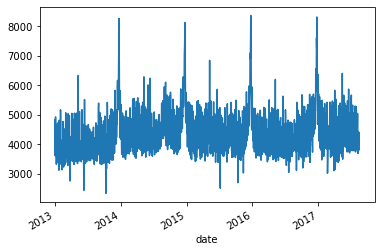

In [207]:
transactions_df.groupby(['store_nbr', 'date'])['transactions'].mean()[44].plot()

<AxesSubplot:>

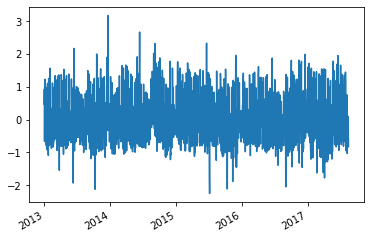

In [208]:
df[44].plot()

In [210]:
df = df.asfreq('d')

In [211]:
model = VAR(df)

In [212]:
lags = list(range(1,13))
best_bic = 100000
best_lag = 1
for lag in lags:
    results = model.fit(lag)
    if results.bic < best_bic:
        best_bic = results.bic
        best_lag = lag
        
print(f"Best Lag: {best_lag} with BIC value at {best_bic}")

Best Lag: 1 with BIC value at -131.14582098589923


In [213]:
results = model.fit(best_lag)

In [214]:
#retrieve the fitted values
df2 = results.fittedvalues

#the store numbers are equal to the column values
items = df2.columns

#forecast 15 days
f = results.forecast_interval(y=df2.values[-results.k_ar:], steps=16)

#set up the dataframe
idx = pd.date_range('2017-08-16','2017-08-31')
df_forecast = pd.DataFrame(f[0],index=idx,columns=items)
df_forecast.head(3)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
2017-08-16,-0.204789,0.146808,0.211977,0.203097,0.240680,0.264324,-0.097774,0.171195,0.166779,0.176880,...,0.315482,0.342099,0.303714,0.303306,0.136475,0.327568,0.331939,-1.600723,0.240801,0.285059
2017-08-17,-0.034477,-0.108092,-0.144404,-0.158446,0.103147,-0.058749,-0.213223,-0.103980,0.091292,0.137434,...,-0.001645,0.051566,-0.007440,0.038986,-0.103545,0.052458,-0.094690,-1.475686,0.201779,0.058872
2017-08-18,0.126906,-0.112669,-0.179365,-0.192544,0.050047,-0.174358,-0.045651,-0.043924,-0.134073,-0.053461,...,-0.074535,-0.104303,-0.128519,-0.123182,-0.133063,-0.083143,-0.064174,-1.355764,0.184405,-0.117417


<AxesSubplot:>

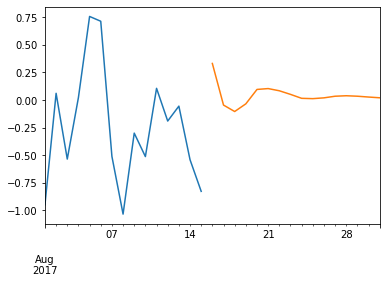

In [215]:
df[(df.index.year == 2017) & (df.index.month == 8)][44].plot()
df_forecast[44].plot()

<AxesSubplot:>

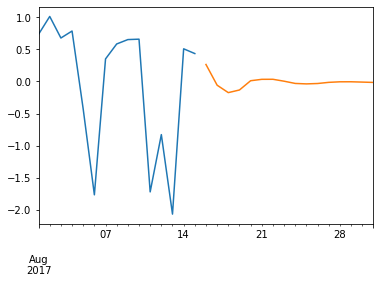

In [216]:
df[(df.index.year == 2017) & (df.index.month == 8)][1].plot()
df_forecast[6].plot()

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> After detrending and adjusting the series for unit variance seasonality...let's see if it is stationary.</span>
</div>

         Values                       Metric
0 -6.397991e+00               D-F Statistics
1  2.028295e-08                      p-value
2  2.000000e+01          number of lags used
3  1.667000e+03  Number of observations used
4 -3.434279e+00          critical value (1%)
5 -2.863275e+00          critical value (5%)
6 -2.567694e+00         critical value (10%)


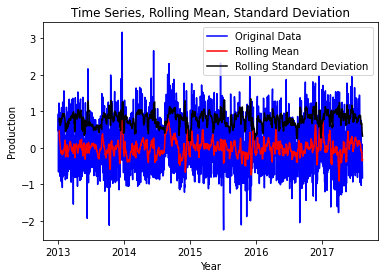

In [219]:
def test_stationarity(df):
    
    # Plot rolling mean and std
    rolling_mean = df.rolling(7).mean()
    rolling_std = df.rolling(7).std()
    
    plt.plot(df, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
    plt.xlabel('Year')
    plt.ylabel('Production')
    plt.title("Time Series, Rolling Mean, Standard Deviation")
    plt.legend(loc="best")
    
    # use the augmented Dickey-Fuller test from the statsmodels package. 
    adft = adfuller(df,autolag='BIC')

    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  ,
                              "Metric":["D-F Statistics","p-value","number of lags used","Number of observations used",
                              "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return print(output_df)
test_stationarity(df[44])

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> The p-value resulting from the Augmented Dickey-Fuller test
                                  is very low showing that the time series is stationary.
                            </span>
</div>

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Now let's look at the seasonal decomposition
                            </span>
</div>

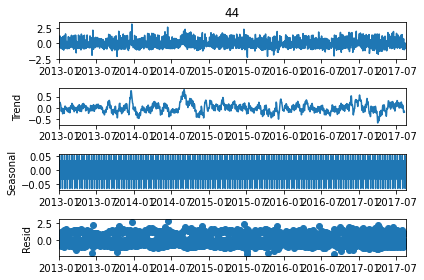

In [217]:
def decomp_ts(ts, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period=12) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                          index = ts.index) )

decomp = decomp_ts(df[44], model='additive')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> And the ACF and PACF plots - these plots are bit disappointing because of clear
                            </span>
</div>

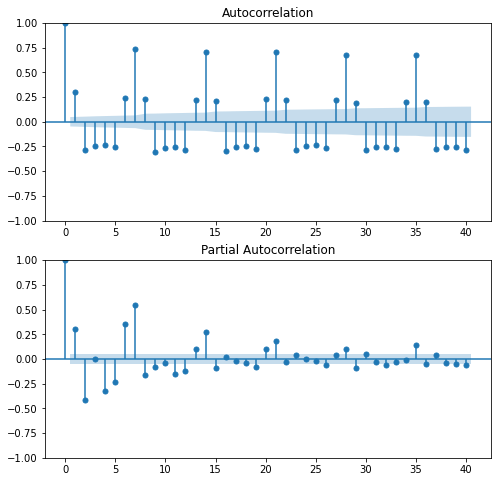

In [218]:
def auto_partial_corr_plot(ts):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags = 40, ax=ax[0]);
    _=splt.plot_pacf(ts, lags = 40, method='yw', ax=ax[1]);

auto_partial_corr_plot(df[44])

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> SARIMAX
                            </span>
</div>

In [222]:
X = X_train[47230504:].copy()   #REDUCE EVEN MORE GIVEN TIME TAKING TO EXPERIMENT

In [224]:
X.drop('Unnamed: 0', axis=1, inplace=True)

In [225]:
X

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
47230504,113689412,2017-04-26,28,1281253,2.000,False
47230505,113689413,2017-04-26,28,1282047,8.563,False
47230506,113689414,2017-04-26,28,1294665,2.000,False
47230507,113689415,2017-04-26,28,1299616,2.000,True
47230508,113689416,2017-04-26,28,1300325,7.000,False
...,...,...,...,...,...,...
59038127,125497035,2017-08-15,54,2089339,4.000,False
59038128,125497036,2017-08-15,54,2106464,1.000,True
59038129,125497037,2017-08-15,54,2110456,192.000,False
59038130,125497038,2017-08-15,54,2113914,198.000,True


In [226]:
items = X.groupby('item_nbr')

In [365]:
import warnings
warnings.filterwarnings(action='once')
seasonal_orders =[ (1, 0, 0, 12),(1, 0, 1, 12),(1, 0, 2, 12),(1, 1, 0, 12),(1, 1, 1, 12),(1, 1, 2, 12),
                   (1, 2, 0, 12),(1, 2, 1, 12),(1, 2, 2, 12),(2, 0, 0, 12),(2, 0, 1, 12),(2, 0, 2, 12),
                   (2, 1, 0, 12),(2, 1, 1, 12),(2, 1, 2, 12),(2, 2, 0, 12),(2, 2, 1, 12),(2, 2, 2, 12)]

orders = [(1, 0, 0),(1, 0, 1),(1, 0, 2),(1, 1, 0),(1, 1, 1),(1, 1, 2),
          (1, 2, 0),(1, 2, 1),(1, 2, 2),(2, 0, 0),(2, 0, 1),(2, 0, 2),
          (2, 1, 0),(2, 1, 1),(2, 1, 2),(2, 2, 0),(2, 2, 1),(2, 2, 2)]

for item_nbr, item_grp in items:
    best_bic = 1000000
    best_order = (1, 0, 0)
    best_seasonal_order = (1, 0, 0, 12)
    items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
    date_index = pd.date_range('2017-04-26', '2017-08-15')
    items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
    for order, seasonal_order in zip(orders, seasonal_orders):
        model = sm.tsa.statespace.SARIMAX(items_daily_sales,order=order, seasonal_order=seasonal_order,
                                          enforce_invertibility=False, enforce_stationarity=False);
        results = model.fit(disp=False);
        if results.bic<best_bic:
            best_bic = results.bic;
            best_seasonal_order = seasonal_order;
            best_order = order;

    break;

/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [366]:
print(best_bic, best_seasonal_order, best_order)

28.108252327400578 (1, 0, 0, 12) (1, 0, 0)


In [367]:
import warnings
warnings.filterwarnings(action='once')
forecasts = []
for item_nbr, item_grp in items:
    items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
    date_index = pd.date_range('2017-04-26', '2017-08-15')
    items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
    model = sm.tsa.statespace.SARIMAX(items_daily_sales,
                                      order=best_order, seasonal_order=best_seasonal_order, 
                                      enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=16)
    df= pd.DataFrame(columns=['item_nbr','date','unit_sales'])
    df['item_nbr']=[item_nbr] * forecast.predicted_mean.index.size
    df['unit_sales']=forecast.predicted_mean.values
    df['date']=forecast.predicted_mean.index
    forecasts.append(df)

/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/csci_e83/lib/python3.9/s

In [368]:
f = pd.concat(forecasts)

In [331]:
f.head(3)

,item_nbr,date,unit_sales
0,96995,2017-08-16,0.990483
1,96995,2017-08-17,0.979141
2,96995,2017-08-18,0.967873


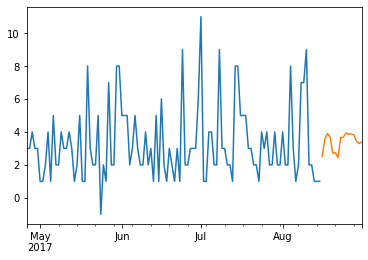

In [354]:
for item_nbr, item_grp in items:
    if item_nbr == 103665:
        items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
        idx = pd.date_range('2017-08-16','2017-08-31')
        f_temp = f[f.item_nbr==103665]['unit_sales']
        f_temp.index = idx
        items_daily_sales.plot()
        f_temp.plot()

In [355]:
f.item_nbr.sample(3)

7    1968073
0    1464091
1     173111
Name: item_nbr, dtype: int64

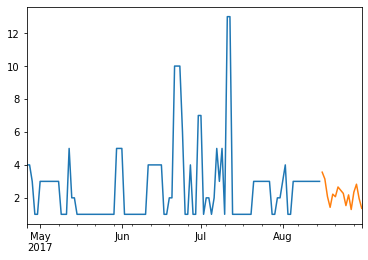

In [358]:
for item_nbr, item_grp in items:
    if item_nbr == 1464091:
        items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
        idx = pd.date_range('2017-08-16','2017-08-31')
        f_temp = f[f.item_nbr==1464091]['unit_sales']
        f_temp.index = idx
        items_daily_sales.plot()
        f_temp.plot()

In [346]:
last_df = pd.merge(X_test,f,on=['item_nbr','date'], how='left')
last_df['unit_sales']=last_df['unit_sales_y'].clip(lower=0)
last_df = last_df.fillna(1)
last_df.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion', 'unit_sales_x', 'unit_sales_y'], axis=1, inplace=True)
last_df.to_csv("sarimax.csv", index=False)

In [343]:
X_test.shape[0]

3370464

In [344]:
last_df.shape[0]

3370464

In [345]:
last_df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            3370454, 3370455, 3370456, 3370457, 3370458, 3370459, 3370460,
            3370461, 3370462, 3370463],
           dtype='int64', length=3370464)

         Values                       Metric
0 -6.133443e+00               D-F Statistics
1  8.295270e-08                      p-value
2  0.000000e+00          number of lags used
3  1.110000e+02  Number of observations used
4 -3.490683e+00          critical value (1%)
5 -2.887952e+00          critical value (5%)
6 -2.580857e+00         critical value (10%)


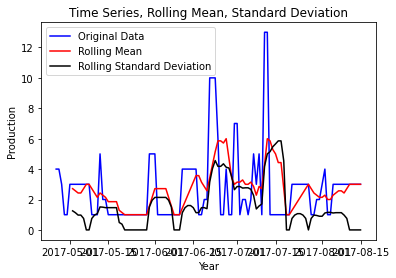

In [373]:

for item_nbr, item_grp in items:
    if item_nbr == 1464091:
        items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
        test_stationarity(items_daily_sales)
        break

         Values                       Metric
0 -9.553202e+00               D-F Statistics
1  2.539224e-16                      p-value
2  0.000000e+00          number of lags used
3  1.110000e+02  Number of observations used
4 -3.490683e+00          critical value (1%)
5 -2.887952e+00          critical value (5%)
6 -2.580857e+00         critical value (10%)


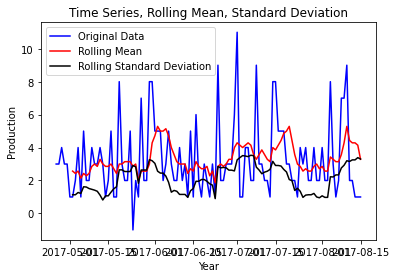

In [374]:

for item_nbr, item_grp in items:
    if item_nbr == 103665:
        items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
        test_stationarity(items_daily_sales)
        break

         Values                       Metric
0 -1.055310e+01               D-F Statistics
1  8.080590e-19                      p-value
2  0.000000e+00          number of lags used
3  1.110000e+02  Number of observations used
4 -3.490683e+00          critical value (1%)
5 -2.887952e+00          critical value (5%)
6 -2.580857e+00         critical value (10%)


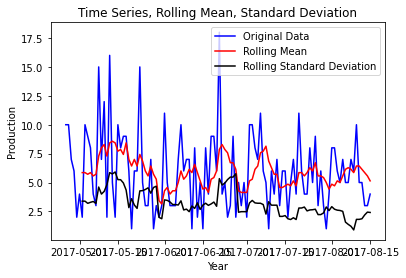

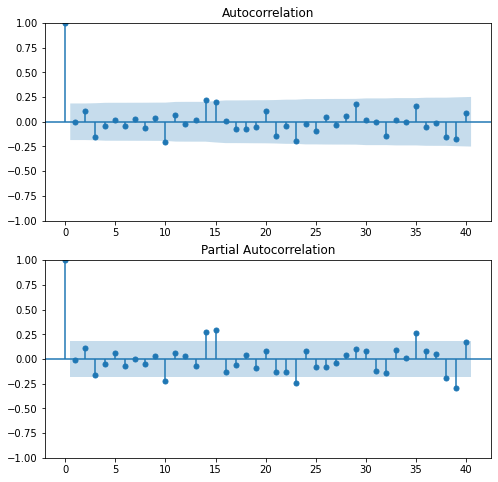

In [377]:
for item_nbr, item_grp in items:
    if item_nbr == 105574:
        items_daily_sales = item_grp.groupby('date')['unit_sales'].mean()
        date_index = pd.date_range('2017-04-26', '2017-08-15')
        items_daily_sales = items_daily_sales.reindex(date_index,method='nearest')
        test_stationarity(items_daily_sales)
        auto_partial_corr_plot(items_daily_sales)
        break

In [ ]:
f_again = pd.concat(forecasts)
onelast_df = pd.merge(X_test,f_again,on=['item_nbr','date'], how='left')
onelast_df['unit_sales']=onelast_df['unit_sales_y'].clip(lower=0)
onelast_df = onelast_df.fillna(1)
onelast_df.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion', 'unit_sales_x', 'unit_sales_y'], axis=1, inplace=True)
onelast_df.to_csv("sarimax2.csv", index=False)